In [1]:
## Imports

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image

import scipy.misc
from skimage import measure   

import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
import pandas as pd

In [2]:
## Dataset Parameters ##
WORKING_DIRECTORY = '/media/dean/49D9D6EB1BE53FC4/datasets/darknet/data'
COCO_ANNOTATIONS_FILE = os.path.join(WORKING_DIRECTORY, 'coco','annotations' , 'fixed_instances_val2014.json')


COCO_FIXES_CSV = os.path.join(WORKING_DIRECTORY, 'COCO_Trucks.csv')
HEADER_ROW=['ID', 'FileName', 'ImageUrl', 'KEEP']

COCO_TRUCK_CAR_DELETES_CSV = os.path.join(WORKING_DIRECTORY, 'coco_cars_trucks.csv')

In [3]:
## Extract Labels ##
image_changes = pd.read_csv(COCO_FIXES_CSV, names=HEADER_ROW, skiprows=1)
image_changes.head()

,ID,FileName,ImageUrl,KEEP
0,155652,COCO_train2014_000000155652.jpg,http://farm3.staticflickr.com/2599/4078412191_...,y
1,253959,COCO_train2014_000000253959.jpg,http://farm4.staticflickr.com/3765/9371427949_...,c
2,253975,COCO_train2014_000000253975.jpg,http://farm1.staticflickr.com/62/211829230_23a...,c
3,188440,COCO_train2014_000000188440.jpg,http://farm2.staticflickr.com/1075/1438769690_...,c
4,417822,COCO_train2014_000000417822.jpg,http://farm9.staticflickr.com/8514/8453715459_...,y


In [4]:
%matplotlib inline
import os
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

coco_directory = '/media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/'

images_directory = os.path.join(coco_directory, 'images','val2014')
fixed_coco = COCO(COCO_ANNOTATIONS_FILE)

/home/dean/miniconda2/envs/ros-kache/lib/python3.6/site-packages/pycocotools/coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/dean/miniconda2/envs/ros-kache/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/dean/miniconda2/envs/ros-kache/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dean/miniconda2/envs/ros-kache/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/dean/miniconda2/envs/ros-kache/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dean/miniconda2/envs/r

loading annotations into memory...
Done (t=4.27s)
creating index...
index created!


In [5]:
import json



filename = COCO_ANNOTATIONS_FILE
with open(filename, 'r') as f:
    data = json.load(f)
    # Make COCO changes
    for image_change in image_changes.as_matrix():
        
        if image_change[3] == 'n':
            #Get all annotations associated with the image
            anns = fixed_coco.getAnnIds(imgIds=[image_change[0]])
            
            #Delete all annotations associated with image
            for d in data['annotations']: # Loops through all the nodes in json object
                if d and int(d['id']) in anns:
                    print('Deleting:', d)
                    data['annotations'].remove(d)
            
        elif image_change[3] == 'c':
            # Change all corresponding labels under image to 'car'
            anns = fixed_coco.getAnnIds(imgIds=[image_change[0]])
            truck_cat = fixed_coco.getCatIds(catNms=['truck'])[0]
            car_cat = fixed_coco.getCatIds(catNms=['car'])[0]
            
            for i, d in enumerate(data['annotations']): # Loops through all the nodes in json object
                for ann in anns:
                    if d and int(d['id']) == int(ann) \
                         and int(d['image_id']) == int(image_change[0]) \
                         and int(d['category_id']) == truck_cat:
                        
                        print('Changing [', d['category_id'] ,']label to car:', d)
                        data['annotations'][i]['category_id'] = car_cat


os.remove(filename)
with open(filename, 'w') as f:
    json.dump(data, f, indent=4)

/home/dean/miniconda2/envs/ros-kache/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [6]:
## Extract Labels ##
image_deletions = pd.read_csv(COCO_TRUCK_CAR_DELETES_CSV, names=HEADER_ROW[:-1], skiprows=1)
image_deletions.head()

,ID,FileName,ImageUrl
0,344067,COCO_train2014_000000344067.jpg,http://farm8.staticflickr.com/7353/9715487608_...
1,114692,COCO_train2014_000000114692.jpg,http://farm3.staticflickr.com/2578/4259448398_...
2,319492,COCO_train2014_000000319492.jpg,http://farm9.staticflickr.com/8428/7718922324_...
3,24585,COCO_train2014_000000024585.jpg,http://farm6.staticflickr.com/5148/5606858964_...
4,114701,COCO_train2014_000000114701.jpg,http://farm3.staticflickr.com/2377/2243712589_...


In [7]:
import json



COCO_ANNOTATIONS_FILE = os.path.join(WORKING_DIRECTORY, 'coco','annotations' , 'fixed_instances_val2014.json')

filename = COCO_ANNOTATIONS_FILE
with open(filename, 'r') as f:
    data = json.load(f)
    # Make COCO changes
    for image_deletion in image_deletions.as_matrix():
        try:
            img_id = int(image_deletion[0])
            #Get all annotations associated with the image
            anns = fixed_coco.getAnnIds(imgIds=[img_id])
            #Delete all annotations associated with image
            for d in data['annotations']: # Loops through all the nodes in json object
                if d and int(d['id']) in anns:
                    print('Deleting:', d)
                    data['annotations'].remove(d)
        except ValueError:
            print('Error casting, skipping img_id:', image_deletion[0])
            continue
     
        
        
        


os.remove(filename)
with open(filename, 'w') as f:
    json.dump(data, f, indent=4)

/home/dean/miniconda2/envs/ros-kache/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Error casting, skipping img_id:  
Error casting, skipping img_id:  


In [8]:
def remove_none(obj):
    if isinstance(obj, (list, tuple, set)):
        return type(obj)(remove_none(x) for x in obj if x is not None)
    elif isinstance(obj, type(dict)):
        return type(obj)((remove_none(k), remove_none(v)) for k, v in obj.items() if k is not None and v is not None)
    else:
        return obj

In [9]:
import json


filename = ''
with open(filename, 'r') as f:
    data = json.load(f)
    #data['annotations'] = remove_none(data['annotations'])
    
    for i, d in enumerate(data['annotations']):
        # Check if width or heigh in bounding box is 0
        if d:
            # xstart, ystart, width, height
            area, bbox = d['area'], d['bbox']
            
            
            if float(bbox[3]) <= 0.0:
                print('Changing BoundingBox/Area Annotations:', bbox,'/',area)
                bbox[3] = 1.1
                data['annotations'][i]['bbox'] = bbox
            if float(bbox[2]) <= 0.0:
                print('Changing BoundingBox/Area Annotations:', bbox,'/',area)
                bbox[2] = 1.1
                data['annotations'][i]['bbox'] = bbox
                
            if float(area) <= 0.0:
                data['annotations'][i]['area'] = float(bbox[2])*float(bbox[3])
                     
        
        
        


os.remove(filename)
with open(filename, 'w') as f:
    json.dump(data, f, indent=4)

Changing BoundingBox/Area Annotations: [296.65, 388.33, 1.03, 0.0] / 0.0


In [10]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [11]:
COCO_ANNOTATIONS_FILE = os.path.join(WORKING_DIRECTORY, 'coco','annotations' , 'fixed_instances_val2014.json')

example_coco = COCO(COCO_ANNOTATIONS_FILE)

loading annotations into memory...
Done (t=6.15s)
creating index...
index created!


In [12]:
categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

supercategory_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(supercategory_names)))

Custom COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

Custom COCO supercategories: 
electronic furniture animal food outdoor sports accessory kitchen appliance person vehicle indoor


In [13]:
category_ids = example_coco.getCatIds(catNms=list(category_names))
image_ids = example_coco.getImgIds()

image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
print(image_data)

{'license': 3, 'file_name': 'COCO_val2014_000000318426.jpg', 'coco_url': 'http://mscoco.org/images/318426', 'height': 370, 'width': 640, 'date_captured': '2013-11-17 08:01:48', 'flickr_url': 'http://farm3.staticflickr.com/2881/9416529849_8fcce8c595_z.jpg', 'id': 318426}


[{'segmentation': [[522.57, 93.19, 478.72, 71.26, 432.12, 64.86, 370.0, 69.43, 335.28, 84.96, 170.84, 160.79, 177.23, 175.41, 378.22, 348.07, 420.25, 346.25, 513.43, 335.28, 539.01, 235.7, 537.19, 174.49, 521.65, 95.01]], 'area': 71113.03235, 'iscrowd': 0, 'image_id': 318426, 'bbox': [170.84, 64.86, 368.17, 283.21], 'category_id': 7, 'id': 1795469}]


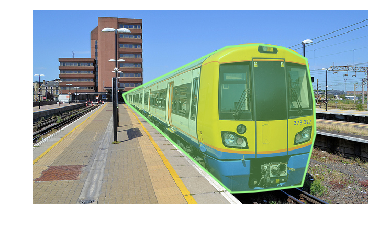

In [14]:
# load and display instance annotations
image = io.imread(os.path.join(images_directory ,image_data['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (68.0, 120.0)
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = example_coco.loadAnns(annotation_ids)
print(annotations)
example_coco.showAnns(annotations)

In [15]:
ann_ids = example_coco.getAnnIds()
print(len(ann_ids))

291875


In [16]:
COCO_ANNOTATIONS_FILE = os.path.join(WORKING_DIRECTORY, 'coco','annotations' , 'instances_val2014.json')

example_coco = COCO(COCO_ANNOTATIONS_FILE)
ann_ids = example_coco.getAnnIds()
print(len(ann_ids))

loading annotations into memory...
Done (t=5.43s)
creating index...
index created!
291875


In [19]:
!java -jar /media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/cocotoyolo.jar "/media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/annotations/fixed_instances_val2014.json" "/media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/images/val2014/" "all" "/media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/labels/fixed_val2014"

Loading annotations...
RootEntry{info=InfoEntry{year=2014, version='1.0', description='This is stable 1.0 version of the 2014 MS COCO dataset.', contributor='Microsoft COCO group', url='http://mscoco.org', dateCreated='2015-01-27 09:11:52.357475'}, # images=40504, # annotations=291875, # licenses=8, # categories=80}


In [24]:
!/media/dean/49D9D6EB1BE53FC4/datasets/darknet/darknet detector test /media/dean/49D9D6EB1BE53FC4/datasets/darknet/cfg/coco.data /media/dean/49D9D6EB1BE53FC4/datasets/darknet/cfg/yolov3.cfg backup/yolov3.backup -dont_show < /media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/labels/fixed_val2014/image_list.txt > /media/dean/49D9D6EB1BE53FC4/datasets/darknet/results/val_2014_results.txt

Couldn't open file: data/coco.names
